In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
import cv2 as cv2
import numpy as np
import os
from scipy.stats import norm


In [3]:
psf_in_pixels = np.load('image.npy')
lattice_grid = np.load('lattice.npy')

psf_in_pixels = psf_in_pixels / psf_in_pixels.sum()

In [4]:
class LatticeDataset(Dataset):
    def __init__(self, image_dir, lattice_points, crop_size=(20,20), image_size=(200, 200)):
        """
        Args:
            image_dir (string): Directory with all the images.
            lattice_points (list of tuples): List of (x, y) tuples indicating the lattice grid points.
            crop_size (tuple): Desired size of the cropped images in pixels as (width, height).
            image_size (tuple): Final image size to crop from (width, height).
        """
        self.image_dir = image_dir
        self.lattice_points = lattice_points
        self.crop_size = crop_size
        self.image_size = image_size
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]


        self.num_crops_x = image_size[0] // crop_size[0]
        self.num_crops_y = image_size[1] // crop_size[1]
        self.total_crops = self.num_crops_x * self.num_crops_y * len(self.image_files)

    def __len__(self):
        return self.total_crops

    def __getitem__(self, idx):
        image_idx = idx // (self.num_crops_x * self.num_crops_y)
        crop_idx = idx % (self.num_crops_x * self.num_crops_y)
        row_idx, col_idx = divmod(crop_idx, self.num_crops_x)

        img_path = os.path.join(self.image_dir, self.image_files[image_idx])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise RuntimeError(f"Failed to load image: {img_path}")

        max_img = np.max(img)
        img = img/max_img

        img_center_x, img_center_y = img.shape[1] // 2, img.shape[0] // 2
        img_start_x, img_start_y = img_center_x - (self.image_size[0] // 2), img_center_y - (self.image_size[1] // 2)
        img_end_x, img_end_y = img_start_x + self.image_size[0], img_start_y + self.image_size[1]
        cropped_img = img[img_start_y:img_end_y, img_start_x:img_end_x]


        x_start = col_idx * self.crop_size[0]
        y_start = row_idx * self.crop_size[1]
        x_end = x_start + self.crop_size[0]
        y_end = y_start + self.crop_size[1]

        final_crop = cropped_img[y_start:y_end, x_start:x_end]

        max_pixel_value = np.max(final_crop)
        normalized_img_1 = (final_crop / max_pixel_value) * np.max(psf_in_pixels)
        max_pixel_value_psf = np.max(normalized_img_1)
        normalized_img = normalized_img_1/max_pixel_value_psf
    
        normalized_img = 2*normalized_img-1

        lattice_positions_in_crop = [
            (x - x_start, y - y_start) for x, y in self.lattice_points
            if x_start <= x < x_end and y_start <= y < y_end
        ]

        normalized_img = torch.tensor(normalized_img, dtype=torch.float32).unsqueeze(0)
        lattice_positions = torch.tensor(lattice_positions_in_crop, dtype=torch.float32)
        return normalized_img, lattice_positions
dataset_train = LatticeDataset(image_dir=r"C:\Users\cristina soler\Documents\UNIVERSITAT\TFG\Deep-learning-reconstruction-in-quantum-gas-microscopes\data\train_images",
                          lattice_points=lattice_grid)

data_loader_train = DataLoader(dataset_train, batch_size=128, shuffle=True)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomAutoencoder(nn.Module):
    def __init__(self):
        super(CustomAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Agrega max pooling para reducción dimensional
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 10, kernel_size=3, stride=1, padding=1),  # Menos canales para un bottleneck más compacto
            nn.Tanh()
        )
        self.unbottleneck = nn.Sequential(
            nn.ConvTranspose2d(10, 128, kernel_size=3, stride=1, padding=1)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),  # Reemplaza transposed conv con upsampling para simplicidad
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 1, kernel_size=5, stride=1, padding=2),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        bottleneck = self.bottleneck(x)
        x = self.unbottleneck(bottleneck)
        decoded = self.decoder(x)
        return decoded, bottleneck


In [6]:
model = CustomAutoencoder()
model.load_state_dict(torch.load(r"C:\Users\cristina soler\Documents\UNIVERSITAT\TFG\Deep-learning-reconstruction-in-quantum-gas-microscopes\models_bons\model_canals_20.pth"))
model.eval()

CustomAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (bottleneck): Sequential(
    (0): Conv2d(128, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
  )
  (unbottleneck): Sequential(
    (0): ConvTranspose2d(10, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode=nearest)
    (3): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4):

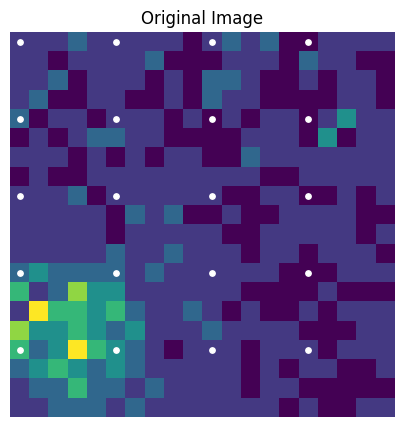

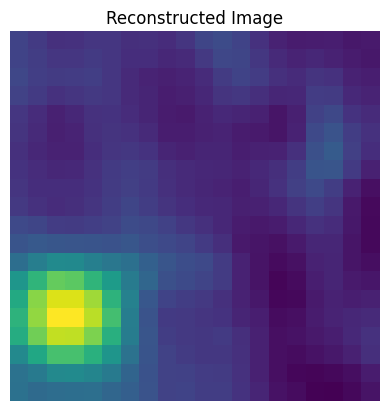

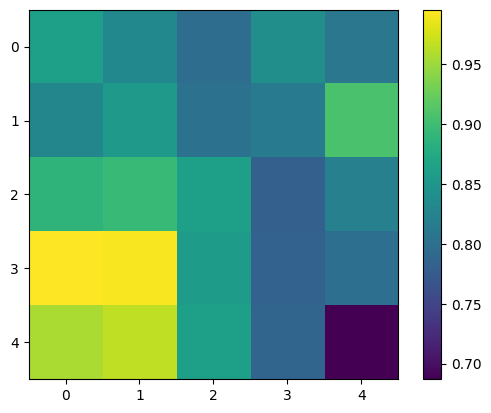

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, image, device):
    """Evaluate the model with a given image on the specified device."""
    
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Send the image to the correct device
    image = image.to(device)
    
    # Add a batch dimension if not present
    if len(image.shape) == 3:
        image = image.unsqueeze(0)
    
    # Make a prediction with the model
    with torch.no_grad():
        reconstructed, bottleneck = model(image)
    
    return reconstructed, bottleneck

# Load the test dataset
dataset_test = LatticeDataset(image_dir=r"data\test_images",
                              lattice_points=lattice_grid)

data_loader_test = DataLoader(dataset_test, batch_size=64, shuffle=True)

# Use the function with an image from your DataLoader
for images, lattice_points in data_loader_test:
    # Assuming you want to test the first image in the batch
    test_image = images[10]
    lattice_def = lattice_points[10]
    break

# Evaluate the model on the test image
reconstructed_image, bottleneck = evaluate_model(model, test_image, 'cpu')

# Squeeze the bottleneck to remove singleton dimensions
bottleneck = bottleneck.squeeze()

# Convert lattice points to numpy array
lattice_def_np = lattice_def.numpy()

# Visualize the original image, reconstructed image, and activations
plt.figure(figsize=(15, 5))

# Plot the original image with lattice points
plt.imshow(test_image.squeeze())
plt.scatter(lattice_def_np[:, 0], lattice_def_np[:, 1], c='white', s=15) 
plt.title('Original Image')
plt.axis('off')
plt.show()

# Plot the reconstructed image
plt.imshow(reconstructed_image.squeeze().cpu())
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()

# Visualize the average activations from the bottleneck
avg_activations = bottleneck[9].squeeze().cpu().numpy()
plt.imshow(avg_activations)
plt.colorbar()
plt.title('Average Activations')
plt.axis('off')
plt.show()


In [8]:
class LatticeImage(Dataset):
    def __init__(self, image_dir, lattice_points, crop_size=(20,20), image_size=(200, 200)):
        """
        Args:
            image_dir (string): Directory with all the images.
            lattice_points (list of tuples): List of (x, y) tuples indicating the lattice grid points.
            crop_size (tuple): Desired size of the cropped images in pixels as (width, height).
            image_size (tuple): Final image size to crop from (width, height).
        """
        self.image_dir = image_dir
        self.lattice_points = lattice_points
        self.crop_size = crop_size
        self.image_size = image_size


        self.num_crops_x = image_size[0] // crop_size[0]
        self.num_crops_y = image_size[1] // crop_size[1]
        self.total_crops = self.num_crops_x * self.num_crops_y

    def __len__(self):
        return self.total_crops

    def __getitem__(self, idx):
        image_idx = idx // (self.num_crops_x * self.num_crops_y)
        crop_idx = idx % (self.num_crops_x * self.num_crops_y)
        row_idx, col_idx = divmod(crop_idx, self.num_crops_x)

        img = cv2.imread(self.image_dir, cv2.IMREAD_GRAYSCALE)
        max_img = np.max(img)
        img = img/max_img

        img_center_x, img_center_y = img.shape[1] // 2, img.shape[0] // 2
        img_start_x, img_start_y = img_center_x - (self.image_size[0] // 2), img_center_y - (self.image_size[1] // 2)
        img_end_x, img_end_y = img_start_x + self.image_size[0], img_start_y + self.image_size[1]
        cropped_img = img[img_start_y:img_end_y, img_start_x:img_end_x]


        x_start = col_idx * self.crop_size[0]
        y_start = row_idx * self.crop_size[1]
        x_end = x_start + self.crop_size[0]
        y_end = y_start + self.crop_size[1]

        final_crop = cropped_img[y_start:y_end, x_start:x_end]

        """ max_pixel_value = np.max(final_crop)
        normalized_img_1 = (final_crop / max_pixel_value) * np.max(psf_in_pixels)
        max_pixel_value_psf = np.max(normalized_img_1)
        normalized_img = normalized_img_1/max_pixel_value_psf
        """

        normalized_img = 2*final_crop-1
        lattice_positions_in_crop = [
            (x - x_start, y - y_start) for x, y in self.lattice_points
            if x_start <= x < x_end and y_start <= y < y_end
        ]

        normalized_img = torch.tensor(normalized_img, dtype=torch.float32).unsqueeze(0)
        lattice_positions = torch.tensor(lattice_positions_in_crop, dtype=torch.float32)
        return normalized_img, lattice_positions

# Example of usage
dataset1 = LatticeImage(image_dir=r"data\2023-09-29_Micro_3p3p3s_ImTest_Good_StepDens2\HopatomsAndor_MOTblue3D_P_0.035_155138.png", lattice_points=lattice_grid)
dataloader1 = DataLoader(dataset1, batch_size=1, shuffle=False)


dataset2 = LatticeImage(image_dir=r"data\2023-09-29_Micro_3p3p3s_ImTest_Good_StepDens2\HopatomsAndor_MOTblue3D_P_0.025_155529.png", lattice_points=lattice_grid)
dataloader2 = DataLoader(dataset2, batch_size=1, shuffle=False)



## PSF comparation 4

In [39]:
radio = 20 / 2
centro_x, centro_y = 33, 33 
inicio_x, inicio_y = int(centro_x - radio), int(centro_y - radio)
fin_x, fin_y = int(centro_x + radio), int(centro_y + radio)

psf_recortada = psf_in_pixels[inicio_y:fin_y, inicio_x:fin_x]
psf_in_pixels = psf_recortada / psf_recortada.sum()

In [ ]:
def gaussian_2d(xy, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude * np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

def plot_gaussian_fit(real_psf, decoded_psf, params_real, params_decoded):
    x = np.linspace(0, real_psf.shape[1] - 1, real_psf.shape[1])
    y = np.linspace(0, real_psf.shape[0] - 1, real_psf.shape[0])
    x, y = np.meshgrid(x, y)
    
    fitted_real_psf = gaussian_2d((x.ravel(), y.ravel()), *params_real).reshape(20,20)
    fitted_decoded_psf = gaussian_2d((x.ravel(), y.ravel()), *params_decoded).reshape(20,20)

    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    # Real PSF and its Gaussian fit
    ax[0, 0].imshow(real_psf, extent=(x.min(), x.max(), y.max(), y.min()), origin='lower')
    ax[0, 0].set_title('Real PSF and Gaussian Fit')

    # Decoded PSF and its Gaussian fit
    ax[0, 1].imshow(decoded_psf, extent=(x.min(), x.max(), y.max(), y.min()), origin='lower')
    ax[0, 1].set_title('Decoded PSF and Gaussian Fit')

    # Detailed view of the Gaussian fit for real PSF
    ax[1, 0].imshow(fitted_real_psf, extent=(x.min(), x.max(), y.max(), y.min()), origin='lower')
    ax[1, 0].set_title('Gaussian Fit - Real PSF')

    # Detailed view of the Gaussian fit for decoded PSF
    ax[1, 1].imshow(fitted_decoded_psf, extent=(x.min(), x.max(), y.max(), y.min()), origin='lower')
    ax[1, 1].set_title('Gaussian Fit - Decoded PSF')

    plt.tight_layout()
    plt.show()

x = np.linspace(0, 19, 20)
y = np.linspace(0, 19, 20)
x, y = np.meshgrid(x, y)
xy = (x.ravel(), y.ravel())

# Suponiendo que tienes real_psf y decoded_output como arrays de NumPy y un rango x_range
real_psf = psf_in_pixels # Tu array real PSF
decoded_output = reconstructed_image.squeeze().cpu().numpy() # La salida del decodificador como array
x_range = np.arange(len(psf_in_pixels))  # Asegúrate de que esto coincida con tus datos


params_real, _ = curve_fit(gaussian_2d, xy, real_psf.ravel(), p0=[1, 10, 10, 3, 3, 0])
params_decoded, _ = curve_fit(gaussian_2d, xy, decoded_output.ravel(), p0=[1, 10, 10, 3, 3, 0])
plot_gaussian_fit(real_psf, decoded_output, params_real, params_decoded)


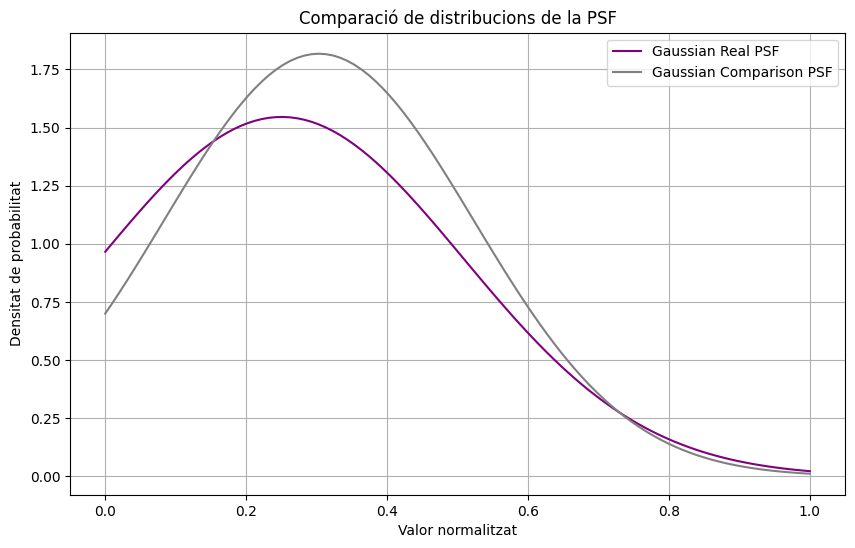

In [78]:
def plot_psf_comparison(image_real, image_comparison):
    """Plot the comparison of PSF distributions between real and comparison images."""
    
    # Normalize the images
    image_real_normalized = (image_real - np.min(image_real)) / (np.max(image_real) - np.min(image_real))
    image_comparison_normalized = (image_comparison - np.min(image_comparison)) / (np.max(image_comparison) - np.min(image_comparison))
    
    # Fit Gaussian distributions to the normalized images
    mean_real, std_real = norm.fit(image_real_normalized)
    mean_comparison, std_comparison = norm.fit(image_comparison_normalized)
    
    # Create data points for the Gaussian distributions
    x = np.linspace(0, 1, 100)
    gaussian_real = norm.pdf(x, mean_real, std_real)
    gaussian_comparison = norm.pdf(x, mean_comparison, std_comparison)
    
    # Plot the Gaussian distributions
    plt.figure(figsize=(10, 6))
    plt.plot(x, gaussian_real, label='Gaussian Real PSF', color='purple')
    plt.plot(x, gaussian_comparison, label='Gaussian Comparison PSF', color='grey')
    plt.title('Comparison of PSF Distributions')
    plt.xlabel('Normalized Value')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with simulated images
image_real = psf_in_pixels  # Simulated real image (values between [0, 1])
image_comparison = reconstructed_image.squeeze().cpu().numpy()  # Simulated comparison image (values between [-1, 1])

plot_psf_comparison(image_real, image_comparison)


In [ ]:
def generate_occupation_matrices(size=(5, 5), threshold=0.75, num_matrices=10):
    """
    Generate occupation matrices based on a threshold applied to simulated activation data.

    Args:
        size (tuple): The dimensions of the matrix (height, width).
        threshold (float): Threshold above which sites are considered occupied.
        num_matrices (int): Number of matrices to generate.

    Returns:
        list: A list of generated occupation matrices.
    """
    matrices = []
    for _ in range(num_matrices):
        # Initialize a zero matrix
        occupation_matrix = np.zeros(size, dtype=int)
        
        # Randomly select a single point to be occupied
        x = np.random.randint(0, size[0])
        y = np.random.randint(0, size[1])
        occupation_matrix[x, y] = 1
        
        matrices.append(occupation_matrix)
    return matrices


def prepare_matrices_for_decoder(matrices, size=(5, 5), num_channels=10, device=torch.device('cpu')):
    """
    Prepares and formats the occupation matrices to match the expected input format of the decoder after the bottleneck.

    Args:
        matrices (list of np.array): List of 2D numpy arrays representing occupation matrices.
        size (tuple): The dimensions of each channel in the matrices.
        num_channels (int): Number of channels to simulate in the bottleneck output.
        device (torch.device): The device (CPU or GPU) to use for processing.

    Returns:
        torch.Tensor: A batch of matrices formatted and ready to be fed to the unbottleneck layer.
    """
    # Initialize a tensor with zeros for all channels
    batch_size = len(matrices)
    stacked_matrices = torch.zeros((batch_size, num_channels, size[0], size[1]), dtype=torch.float32)

    # Populate each channel with the same occupation matrix (for simplicity, or you can vary it per channel)
    for i in range(num_channels):
        stacked_matrices[:, i, :, :] = torch.tensor(matrices, dtype=torch.float32)

    return stacked_matrices.to(device)

def feed_to_decoder(model, prepared_matrices):
    """
    Feed an occupation matrix to the decoder and get the output.
    """
    model.eval()  # Set the model to evaluation mode if not already
    with torch.no_grad():  # Ensure gradients are not computed
        # Since we simulate passing through the bottleneck, start decoding after the bottleneck
        x = model.unbottleneck(prepared_matrices)
        decoded = model.decoder(x)
    return decoded

def compare_with_psf(decoder_output, psf_image):
    """
    Compare decoder output with PSF image visually.
    """

    if decoder_output.dim() == 4 and decoder_output.size(1) == 1:
        # Assuming decoder_output is a batch of grayscale images
        decoder_output = decoder_output.squeeze(1)  # Remove channel dimension if it's 1
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    # Select the first image from the batch for visualization
    ax[0].imshow(decoder_output[0].numpy(), cmap='gray')
    ax[0].set_title("Decoder Output")
    ax[1].imshow(psf_image, cmap='gray')
    ax[1].set_title("Measured PSF")
    plt.show()

    # Optionally, plot a cut through the center of the 2D images
    center_line_decoder = decoder_output[decoder_output.shape[0]//2, :]
    center_line_psf = psf_image[psf_image.shape[0]//2, :]
    plt.figure(figsize=(12, 6))
    plt.plot(center_line_decoder, label='Decoder Output')
    plt.plot(center_line_psf, label='Measured PSF')
    plt.title("Center Line Comparison")
    plt.legend()
    plt.show()


# Example of feeding a single site or a group of sites
occupation_matrix = generate_occupation_matrices()
prepared_matrices = prepare_matrices_for_decoder(occupation_matrix, device='cpu')

output_image = feed_to_decoder(model, prepared_matrices)
compare_with_psf(output_image, psf_in_pixels)


In [ ]:
def compare_with_psf_new(decoder_output, psf_image):
    """
    Compare decoder output with PSF image visually and quantitatively.
    """
    if decoder_output.dim() == 4 and decoder_output.size(1) == 1:
        decoder_output = decoder_output.squeeze(1)  # Remove channel dimension if it's 1
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(decoder_output[0].numpy(), cmap='hot')
    ax[0].set_title("Decoder Output")
    ax[1].imshow(psf_image, cmap='hot')
    ax[1].set_title("Measured PSF")
    plt.show()

    center_line_decoder = decoder_output[0, decoder_output.shape[2]//2, :].cpu().numpy()
    center_line_psf = psf_image[psf_image.shape[0]//2, :]

    plt.figure(figsize=(12, 6))
    plt.plot(center_line_decoder, label='Decoder Output')
    plt.plot(center_line_psf, label='Measured PSF')
    plt.title("Center Line Comparison")
    plt.legend()
    plt.show()

    mean_difference = np.mean(np.abs(center_line_decoder - center_line_psf))
    correlation = np.corrcoef(center_line_decoder, center_line_psf)[0, 1]

    print(f"Mean Difference: {mean_difference}")
    print(f"Correlation: {correlation}")

compare_with_psf_new(reconstructed_image, psf_in_pixels)


In [148]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def generate_occupation_matrices(size=(5, 5), fill_levels=None, num_matrices_per_level=10):
    if fill_levels is None:
        fill_levels = np.linspace(0, 1, 100)  # Genera 11 niveles de llenado de 0 a 1
    matrices_dict = {}
    for fill_level in fill_levels:
        matrices = []
        for _ in range(num_matrices_per_level):
            matrix = np.random.rand(size[0], size[1]) < fill_level
            matrices.append(matrix.astype(int))
        matrices_dict[fill_level] = matrices
    return matrices_dict

matrices_by_fill_level = generate_occupation_matrices()

In [149]:
from scipy.signal import convolve2d

def decode_matrices(model, matrices_dict):
    decoded_images = {}
    for fill_level, matrices in matrices_dict.items():
        decoded_per_level = []
        for matrix in matrices:
            # Convertir la matriz en un tensor adecuado para pasar por todo el modelo
            input_tensor = torch.tensor(matrix, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            with torch.no_grad():
                decoded, _ = model(input_tensor)  # Asume que el modelo devuelve tanto el decoded como el bottleneck
                decoded = decoded.squeeze().numpy()  # Remover dimensiones innecesarias
            decoded_per_level.append(decoded)
        decoded_images[fill_level] = decoded_per_level
    return decoded_images


def convolve_with_psf(matrices_dict, psf):
    convolved_images = {}
    for fill_level, matrices in matrices_dict.items():
        convolved_per_level = []
        for matrix in matrices:
            convolved_image = convolve2d(matrix, psf, mode='same', boundary='wrap')
            convolved_per_level.append(convolved_image)
        convolved_images[fill_level] = convolved_per_level
    return convolved_images

def process_and_decode_experimental_images(model, dataloader):
    decoded_intensities = []
    for images, _ in dataloader:
        images = images.to('cpu')  # Asumiendo que el modelo y los datos están en el mismo dispositivo
        with torch.no_grad():
            decoded_images = model(images)
            # Normalizar las imágenes decodificadas si es necesario
            decoded_images = (decoded_images - decoded_images.min()) / (decoded_images.max() - decoded_images.min())
            mean_intensity = decoded_images.mean(dim=[2, 3])  # Promedio sobre las dimensiones espaciales
            decoded_intensities.extend(mean_intensity.cpu().numpy())
    return np.mean(decoded_intensities)


decoded_images = decode_matrices(model, matrices_by_fill_level)
convolved_images = convolve_with_psf(matrices_by_fill_level, psf_in_pixels)





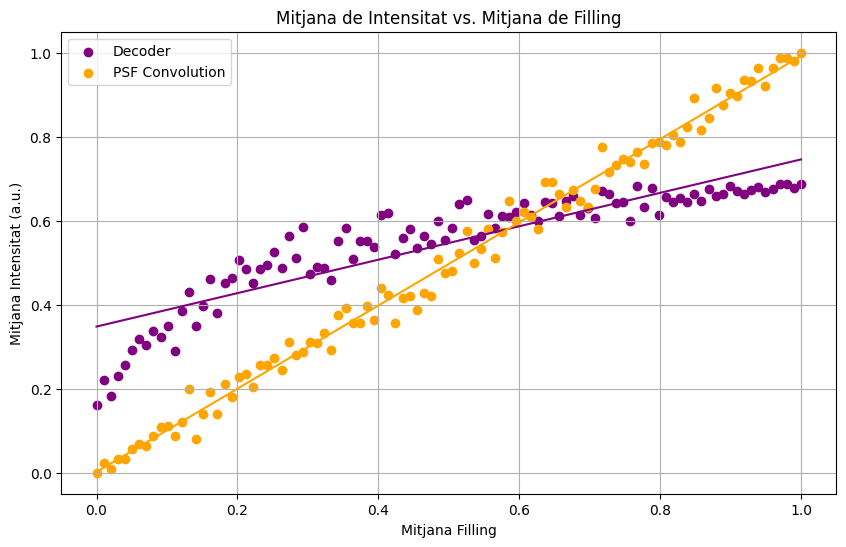

In [150]:
def calculate_mean_intensity(images_dict):
    mean_intensities = {}
    for fill_level, images in images_dict.items():
        intensities = [np.mean(image) for image in images]
        mean_intensities[fill_level] = np.mean(intensities)
    return mean_intensities

mean_intensities_decoded = calculate_mean_intensity(decoded_images)
mean_intensities_convolved = calculate_mean_intensity(convolved_images)
mean_intensities_experimental = process_experimental_images(dataloader1)


def fit_linear_model(fill_levels, mean_intensities):
    coefficients = np.polyfit(fill_levels, list(mean_intensities.values()), 1)
    return coefficients

coefficients_decoded = fit_linear_model(np.linspace(0, 1, 100), mean_intensities_decoded)
coefficients_convolved = fit_linear_model(np.linspace(0, 1, 100), mean_intensities_convolved)



def plot_results(fill_levels, mean_intensities_decoded, mean_intensities_convolved):
    plt.figure(figsize=(10, 6))
    plt.scatter(fill_levels, list(mean_intensities_decoded.values()), color='purple', label='Decoder')
    plt.plot(fill_levels, np.polyval(np.polyfit(fill_levels, list(mean_intensities_decoded.values()), 1), fill_levels), color='purple')
    
    plt.scatter(fill_levels, list(mean_intensities_convolved.values()), color='orange', label='PSF Convolution')
    plt.plot(fill_levels, np.polyval(np.polyfit(fill_levels, list(mean_intensities_convolved.values()), 1), fill_levels), color='orange')
    

    
    plt.title('Mitjana de Intensitat vs. Mitjana de Filling')
    plt.xlabel('Mitjana Filling')
    plt.ylabel('Mitjana Intensitat (a.u.)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_results(np.linspace(0, 1, 100), mean_intensities_decoded, mean_intensities_convolved)


In [107]:
def convolve_with_psf(matrices, psf):
    psf_resized = cv2.resize(psf, (matrices[0].shape[0], matrices[0].shape[1]), interpolation=cv2.INTER_AREA)
    convolved_matrices = []
    for matrix in matrices:
        convolved = cv2.filter2D(matrix.astype(float), -1, psf_resized)
        convolved_matrices.append(convolved)
    return convolved_matrices

convolved_images = convolve_with_psf(occupation_matrices, psf_in_pixels)

In [43]:
def visualize_bottleneck_on_image(model, dataloader, threshold):
    """
    Visualize the bottleneck layer activations of the autoencoder over the real background image.
    Considering a subgrid of 5x4 in each subimage of 20x20 pixels within a 200x200 image.

    Args:
        model (torch.nn.Module): The autoencoder model.
        dataloader (torch.utils.data.DataLoader): DataLoader that provides the images.
        threshold (float): Threshold to determine the occupancy in the visualization.
    """
    model.eval()  
    device = next(model.parameters()).device  # Assume the model is on the correct device

    # Prepare the final composite image
    full_image = np.zeros((200, 200))
    activation_points = []
    no_activated = []

    for i, (image, _) in enumerate(dataloader):
        input_image = image.to(device)
        with torch.no_grad():
            _, bottleneck = model(input_image)

        # Extract the real image and resize it
        real_image = image.squeeze().cpu().numpy()
        row_base = (i // 10) * 20
        col_base = (i % 10) * 20
        full_image[row_base:row_base + 20, col_base:col_base + 20] = real_image

        # Extract the specific activation for visualization
        activation = bottleneck.squeeze()[9].cpu().numpy()

        # Add activation points
        for r in range(5):
            for c in range(4):
                if activation[r, c] > threshold:
                    activation_points.append((col_base + c * 5 + 2.5, row_base + r * 4 + 2))
                else:
                    no_activated.append((col_base + c * 5 + 2.5, row_base + r * 4 + 2))

    # Draw the background image with the activations
    plt.figure(figsize=(10, 10))
    plt.imshow(full_image, extent=[0, 200, 200, 0])
    x_points, y_points = zip(*activation_points)
    plt.scatter(x_points, y_points, color='none', s=40, label='Active', edgecolors='w')  # Active points
    plt.title("Bottleneck Activations on Full Image (200x200)")
    plt.axis('off')
    plt.show()

    return full_image, activation_points, no_activated


Text(0, 0.5, 'Fidelitat')

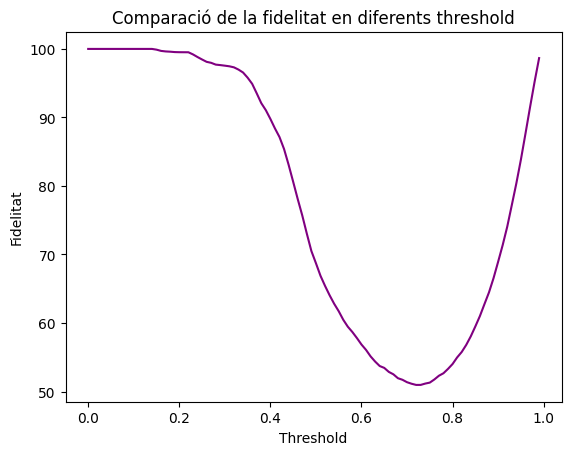

In [33]:
threshold = []
fid = []
for llave, valores in threshold_list.items():
    if valores: 
        media = sum(valores) / len(valores)
        threshold.append(llave)
        fid.append(media)


plt.plot(threshold, fid, color='purple')

plt.title('Comparació de la fidelitat en diferents threshold')
plt.xlabel('Threshold')
plt.ylabel('Fidelitat')


In [45]:
for i, (image, _) in enumerate(dataloader1):
    image_1 = image

for i, (image, _) in enumerate(dataloader2):
    image_2 = image

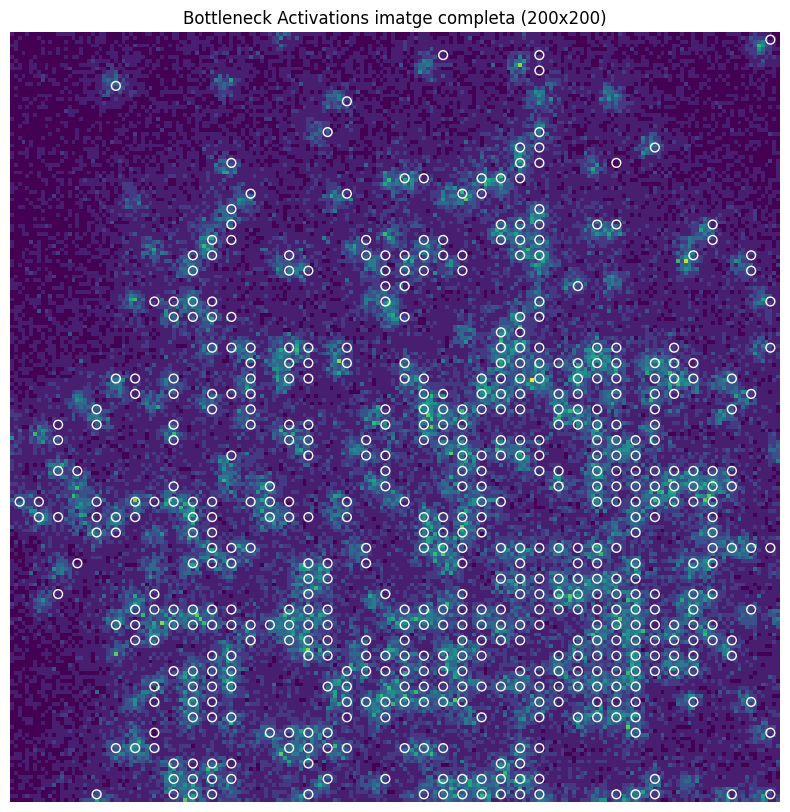

In [58]:
_, activation_point1, no_activated_1 = visualize_bottleneck_on_image(model, dataloader1, threshold=0.80)

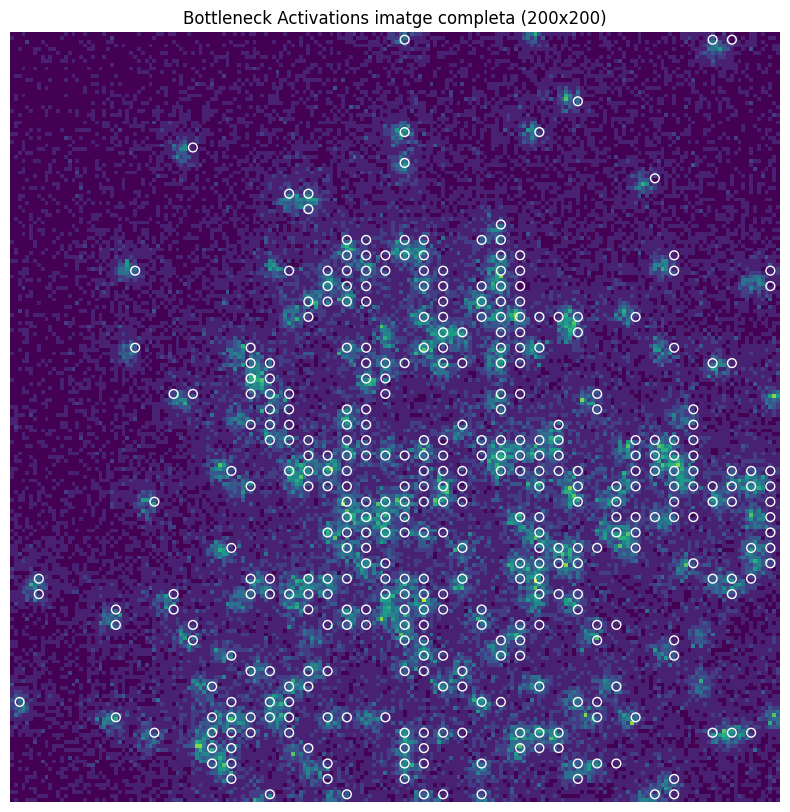

In [59]:
_, activation_point2, no_activated_2 = visualize_bottleneck_on_image(model, dataloader2, threshold=0.80)

In [61]:
def calculate_lattice_fidelity(activation_points1, no_activated1, activation_points2, no_activated2):
    """
    Calculate the fidelity of lattice activation between two sets of points.

    Parameters:
        activation_points1, no_activated1: Lists of tuples for the first lattice.
        activation_points2, no_activated2: Lists of tuples for the second lattice.

    Returns:
        float: The fidelity percentage.
    """
    # Create sets from lists for easy comparison
    set_activated1 = set(activation_points1)
    set_no_activated1 = set(no_activated1)
    set_activated2 = set(activation_points2)
    set_no_activated2 = set(no_activated2)
    
    # Calculate matches
    correct_activated_matches = len(set_activated1.intersection(set_activated2))
    # Calculate correct matches for non-activated points
    correct_no_activated_matches = len(set_no_activated1.intersection(set_no_activated2))

    # Calculate mismatches for activated points
    activated_mismatches = len(set_activated1.symmetric_difference(set_activated2))
    # Calculate mismatches for non-activated points
    no_activated_mismatches = len(set_no_activated1.symmetric_difference(set_no_activated2))

    # Total matches and mismatches
    total_matches = correct_activated_matches + correct_no_activated_matches
    total_mismatches = activated_mismatches + no_activated_mismatches

    # Total comparisons
    total_comparisons = total_matches + total_mismatches

    # Fidelity calculation
    fidelity = (total_matches / total_comparisons) * 100 if total_comparisons > 0 else 100  # Avoid division by zero

    return fidelity

In [62]:
calculate_lattice_fidelity(activation_point1, no_activated_1, activation_point2, no_activated_2)

52.67175572519084

In [ ]:
threshold_list = []
fidelity = []
for threshold in range(0, 100):
    t = threshold*0.01
    print(t)
    _, activation_point1, no_activated_1 = visualize_bottleneck_on_image(model, dataloader1, threshold=t)
    _, activation_point2, no_activated_2 = visualize_bottleneck_on_image(model, dataloader2, threshold=t)
    threshold_list.append(threshold*0.01)
    fide = calculate_lattice_fidelity(activation_point1, no_activated_1, activation_point2, no_activated_2)
    print(fide)
    fidelity.append(fide)
    

Text(0, 0.5, 'Fidelitat')

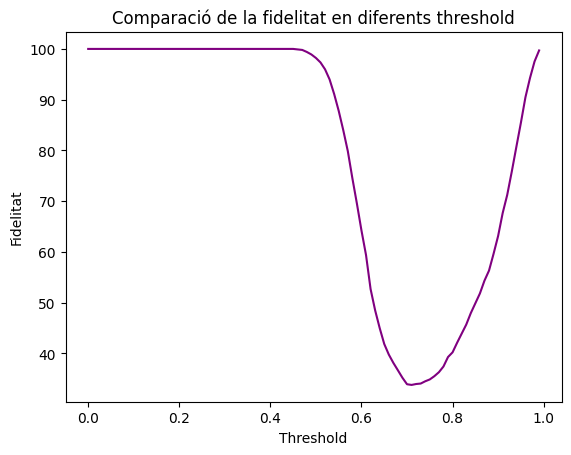

In [53]:
plt.plot(threshold_list, fidelity, color='purple')

plt.title('Comparació de la fidelitat en diferents threshold')
plt.xlabel('Threshold')
plt.ylabel('Fidelitat')

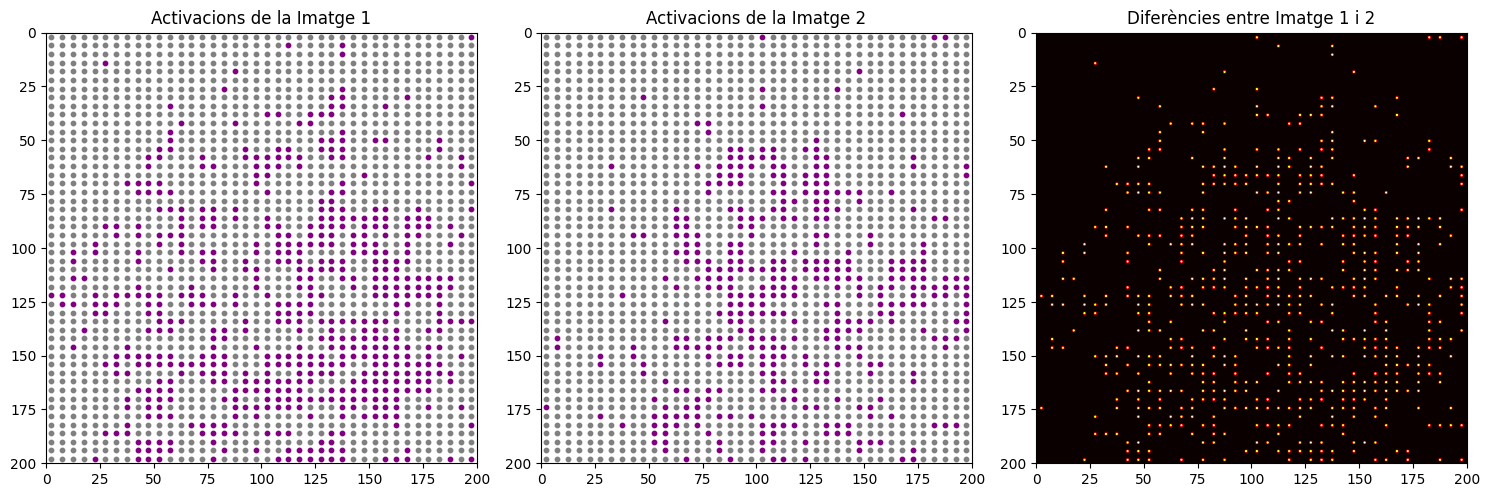

In [63]:
def points_to_mask(points, image_size=(200, 200)):
    """
    Convert list of points to a binary mask.

    Parameters:
        points (list of tuples): List of (x, y) points.
        image_size (tuple): Dimensions of the mask.

    Returns:
        np.array: Binary mask of the points.
    """
    mask = np.zeros(image_size)
    for x, y in points:
        if 0 <= int(y) < image_size[0] and 0 <= int(x) < image_size[1]:
            mask[int(y), int(x)] = 1
    return mask

def visualize_activation_differences(activation_points1, no_activated1, activation_points2, no_activated2, image_size=(200, 200)):
    """
    Visualize the differences in activation between two images.

    Parameters:
        activation_points1 (list): Activation points from the first image.
        no_activated1 (list): No activation points from the first image.
        activation_points2 (list): Activation points from the second image.
        no_activated2 (list): No activation points from the second image.
        image_size (tuple): Dimensions of the image.
    """
    # Generate masks for both sets of points
    mask1_active = points_to_mask(activation_points1, image_size)
    mask2_active = points_to_mask(activation_points2, image_size)

    total_points = len(activation_point1) + len(no_activated_1)

    # Create a figure and a set of subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Image 1 Activations
    axs[0].imshow(mask1_active, cmap='Greys', extent=[0, image_size[1], image_size[0], 0])
    axs[0].scatter(*zip(*activation_points1), color='purple', s=10, label='Punts actius imatge 1')
    axs[0].scatter(*zip(*no_activated1), color='grey', s=10, label='Punts inactius imatge 1')
    axs[0].set_title('Activacions de la Imatge 1')

    # Image 2 Activations
    axs[1].imshow(mask2_active, cmap='Greys', extent=[0, image_size[1], image_size[0], 0])
    axs[1].scatter(*zip(*activation_points2), color='purple', s=10, label='Punts actius imatge 2')
    axs[1].scatter(*zip(*no_activated2), color='grey', s=10, label='Punts inactius imatge')
    axs[1].set_title('Activacions de la Imatge 2')

    # Difference Visualization
    difference_mask = np.abs(mask1_active - mask2_active)
    axs[2].imshow(difference_mask, cmap='hot', extent=[0, image_size[1], image_size[0], 0])
    axs[2].set_title('Diferències entre Imatge 1 i 2')
    
    plt.tight_layout()
    plt.show()

visualize_activation_differences(activation_point1, no_activated_1, activation_point2, no_activated_2)

C:\Users\cristina soler\AppData\Local\Temp\ipykernel_5924\932593271.py:56: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x, p_left, 'r--', color='purple', label='Llocs buits')


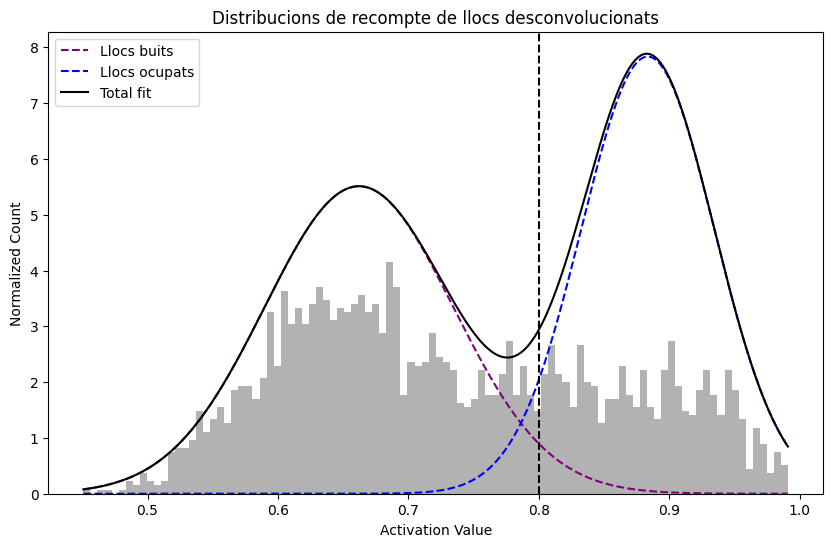

In [62]:
def extract_bottleneck_activations(model, dataloader):
    """
    Extracts the activations from the bottleneck layer before binarization.

    Args:
        model (torch.nn.Module): The autoencoder model.
        dataloader (torch.utils.data.DataLoader): DataLoader that provides the images.

    Returns:
        activations (list): List of activations from the bottleneck layer.
    """
    model.eval()
    device = next(model.parameters()).device  # Get the device of the model parameters

    activations = []

    for image, _ in dataloader:
        input_image = image.to(device)
        with torch.no_grad():  # No gradient calculation
            _, bottleneck = model(input_image)
        
        # Extract and flatten the activations
        activation = bottleneck.squeeze()[9].cpu().numpy()
        activations.extend(activation.flatten())

    return activations

def plot_deconvolved_site_count_distribution(activations, threshold=0.8):
    """
    Plots the deconvolved site count distributions from the bottleneck activations.

    Args:
        activations (list): List of activations from the bottleneck layer.
        threshold (float): Threshold to determine site occupancy.
    """
    # Convert activations to numpy array for easier handling
    activations = np.array(activations)
    
    # Histogram of the activations
    plt.figure(figsize=(10, 6))
    counts, bins, _ = plt.hist(activations, bins=100, color='gray', alpha=0.6, density=True)

    # Fit two Gaussian distributions to the data
    midpoint = len(bins) // 2
    left_peak = activations[activations <= threshold]
    right_peak = activations[activations > threshold]
    
    # Fit Gaussian distributions
    params_left = norm.fit(left_peak)
    params_right = norm.fit(right_peak)

    x = np.linspace(bins[0], bins[-1], 1000)
    p_left = norm.pdf(x, *params_left)
    p_right = norm.pdf(x, *params_right)

    # Plot the fitted Gaussian distributions
    plt.plot(x, p_left, 'r--', color='purple', label='Empty Sites')
    plt.plot(x, p_right, 'b--', label='Occupied Sites')
    plt.plot(x, p_left + p_right, 'k-', label='Total fit')

    # Add a vertical line at the threshold
    plt.axvline(threshold, color='k', linestyle='--')
    plt.xlabel('Activation Value')
    plt.ylabel('Normalized Count')
    plt.title('Deconvolved Site Count Distributions')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
occupation_counts = extract_bottleneck_activations(model, dataloader1)
plot_deconvolved_site_count_distribution(occupation_counts)


In [22]:
def extract_bottleneck_activations_per_channel(model, dataloader, device):
    """
    Extract bottleneck activations for each channel separately from the model for all data in the dataloader.

    Args:
        model (torch.nn.Module): The trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader providing the data.
        device (torch.device): The device on which the model is loaded.

    Returns:
        dict: A dictionary where keys are channel indices and values are lists of activations for that channel.
    """
    model.eval()  # Set the model to evaluation mode.
    activations_per_channel = {i: [] for i in range(10)}  # Assuming 10 channels

    with torch.no_grad():  # No need to track gradients
        for data, _ in dataloader:
            data = data.to(device)
            _, bottleneck = model(data)  # Assuming your model returns output, bottleneck
            for i in range(10):  # Assuming 10 channels
                activations_per_channel[i].extend(bottleneck[:, i, :, :].cpu().numpy().flatten())

    return activations_per_channel

activations_per_channel = extract_bottleneck_activations_per_channel(model, dataloader1, 'cpu')


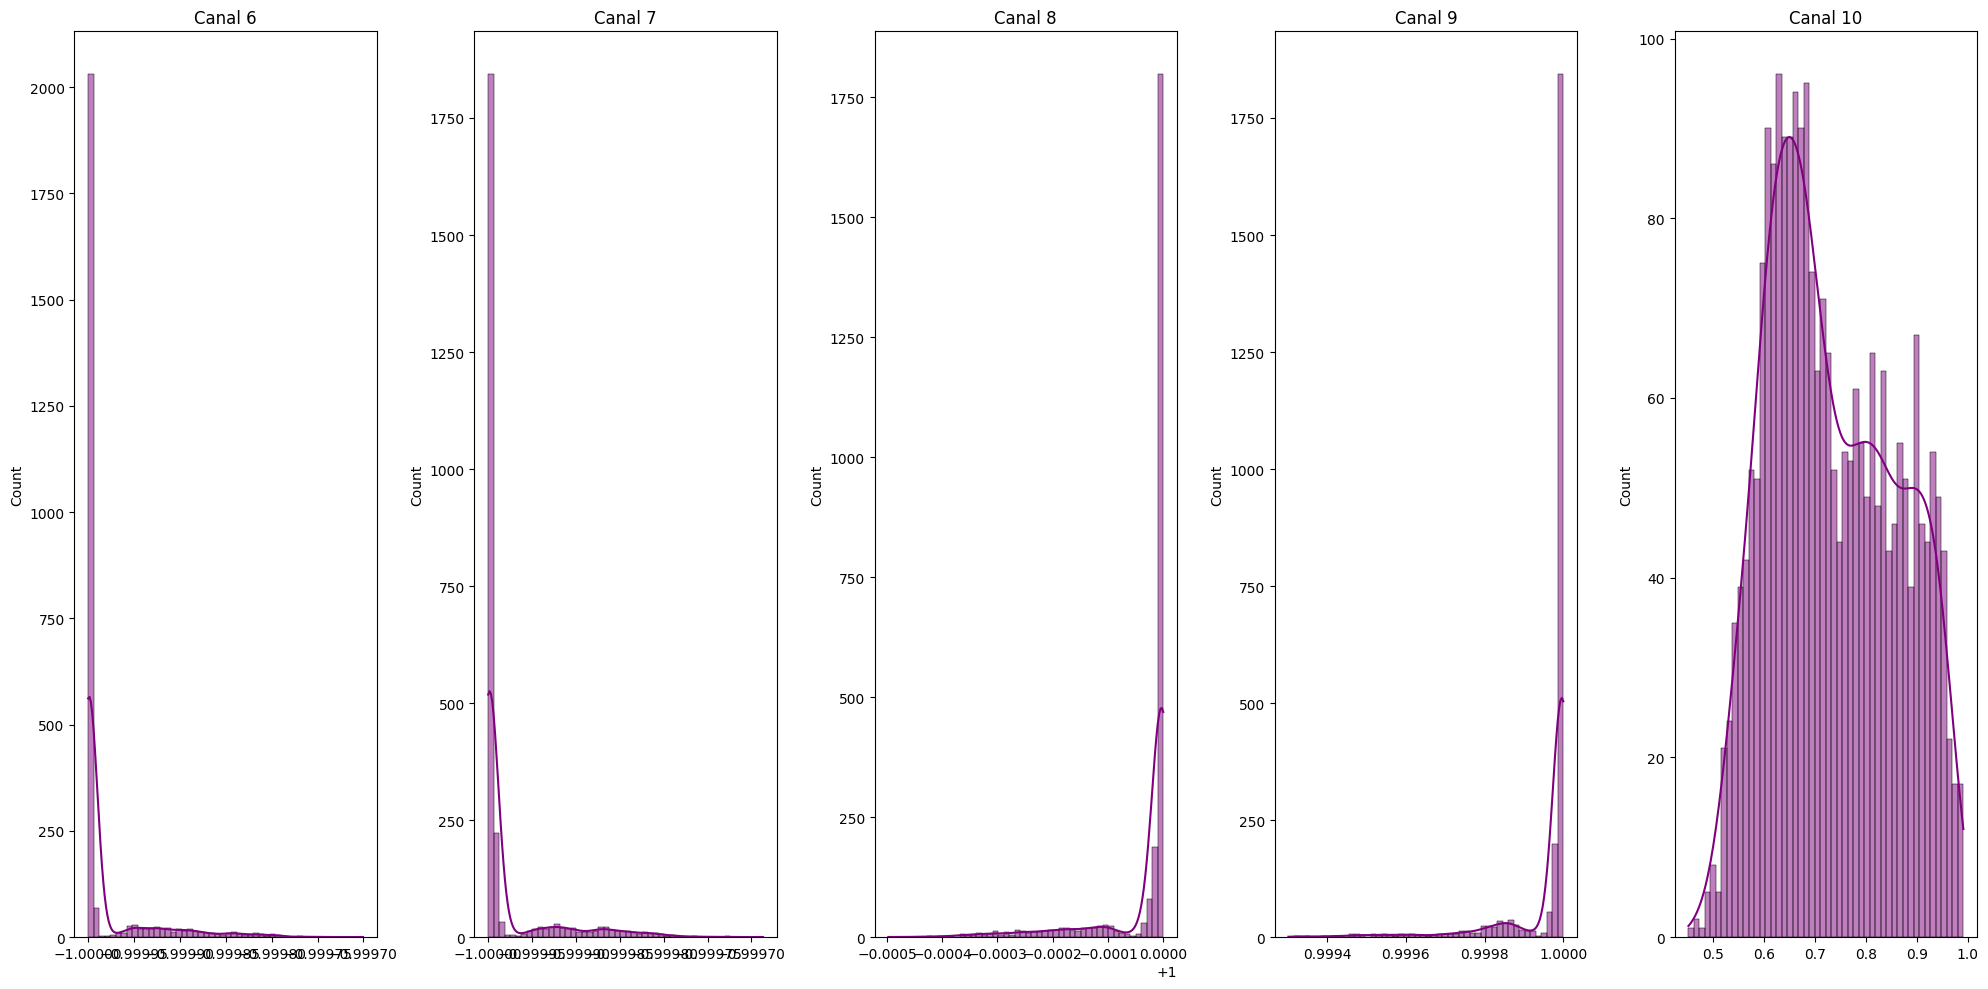

In [28]:
import seaborn as sns
def plot_activation_distributions(activations_per_channel):
    """
    Plot activation distributions for each channel.
    
    Args:
        activations_per_channel (dict): A dictionary of activations lists per channel.
    """
    plt.figure(figsize=(20, 10))
    for i in range(5, 10):
        plt.subplot(1, 5, i-5+1)
        sns.histplot(activations_per_channel[i], bins=50, kde=True, color='purple')
        plt.title(f'Canal {i+1}')
    plt.tight_layout()
    plt.show()


plot_activation_distributions(activations_per_channel)

In [29]:
from skimage.filters import threshold_otsu

def calculate_optimal_thresholds(activations_per_channel):
    """
    Calculate optimal thresholds for each channel using Otsu's method.
    
    Args:
        activations_per_channel (dict): A dictionary of activations lists per channel.
    
    Returns:
        dict: A dictionary of optimal thresholds per channel.
    """
    optimal_thresholds = {}
    for i in range(10):
        threshold = threshold_otsu(np.array(activations_per_channel[i]))
        optimal_thresholds[i] = threshold
    return optimal_thresholds

calculate_optimal_thresholds(activations_per_channel)


{0: -0.9999567,
 1: -0.9073723,
 2: 0.9999516,
 3: -0.9999168,
 4: 0.9637277,
 5: -0.9999444,
 6: -0.99994063,
 7: 0.99988437,
 8: 0.9998295,
 9: 0.74940455}